This is a small project to understand extraction of priors from target coordinates of train data in object detection tasks.
data is taken from [here](https://www.kaggle.com/datasets/sshikamaru/car-object-detection/data)

In [1]:
import numpy as np
import pandas as pd
import sklearn
#data is in csv format

It uses <b>Kmeans Clustering technique</b> to bring the coordinates together.

In [2]:
df= pd.read_csv('./train_solution_bounding_boxes (1).csv')

In [3]:
df

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422
...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864


around 559 rows present xmin,xmax,ymin,ymax are the things we are looking for, we need to map them to priors.

In [4]:
df.describe()

,xmin,ymin,xmax,ymax
count,559.000000,559.000000,559.000000,559.000000
mean,263.387486,186.517539,365.324845,231.500472
std,207.368388,9.315974,213.501175,13.987176
min,0.000000,148.399292,28.556446,198.321729
25%,61.387844,180.109294,166.309696,223.225547
50%,236.746744,187.524131,348.585579,230.561454
75%,446.835022,193.881918,571.322721,237.897362
max,645.183792,208.064672,676.000000,308.322072


So using given 2 coordinate pairs we can create a rectangle, is it needed though, to create target ones, i need just 2 pairs again not one pair but two, to make these pairs i need 4 floats, in which i can pick max, min out of them, 2 must be bounded by xaxis and other 2 by yaxis
so choosing 4 numbers, which will represent the rectangle is what to do, so this is 2 clustering problems in one, clustering x axis ones is independent from y axis ones clustering,it can also be posed as taking 4 coordinates as one point in clustering, then also it may work,
difference is that this looks much better than previous ones,though they are independent, previous ones are complicated this is simpler.

We are tyring to make a cluster out of the data using 4 corodinates, min max if issues arise we can swap them.

In [5]:
data= df[df.columns.difference(['image'])].to_numpy()

In [6]:
data

array([[327.7279305 , 281.2590449 , 223.225547  , 187.0350708 ],
       [120.3299566 ,  15.16353111, 236.4301802 , 187.0350708 ],
       [361.9681621 , 239.1924747 , 236.4301802 , 176.7648005 ],
       ...,
       [141.7975237 ,   0.        , 239.1766516 , 168.2958225 ],
       [616.9176985 , 487.4289876 , 228.839864  , 172.2336464 ],
       [348.585579  , 221.5586307 , 238.1921956 , 182.5704339 ]])

In [7]:
#min max scaling is to be done, storing them as will be needed to reconstruct back the results
D_max,D_min= data.max(axis= 0),data.min(axis= 0)
data = (data- D_min)/(D_max-D_min)

In [8]:
data

array([[0.46208118, 0.43593632, 0.22639764, 0.64754098],
       [0.14174751, 0.02350265, 0.34643938, 0.64754098],
       [0.51496646, 0.37073541, 0.34643938, 0.47540984],
       ...,
       [0.17490494, 0.        , 0.37140723, 0.3334686 ],
       [0.90874525, 0.75548858, 0.27743672, 0.39946707],
       [0.49429658, 0.3434039 , 0.36245765, 0.57271305]])

Kmeans Clustering
if 4 points are considered seperately we assume that they are independent, we will get priors where the model assumes them to be on 4 dimensions, actually is 2 dimensions,is some data lost because of this we are trying to min max normalize them, all we need are 4 floats which represent the data, like diverse representations like some will be small or some will be in the corner, some will be in the center, but they should be common. So here the model sees the same if they are common data is still representative of that, if a point (0.1,0.2,0.5,0.6) after sclaing, if there are many points in that region it will be shown,despite changes in scale.

what to fix for the number of clusters, we will do an elbow plot, on dunn index, even after finding clusters we can need to search within the neighborhood of the cluster to get precise box coordinates, this is further to be seen on how things work.

In [9]:
from sklearn.cluster import KMeans

In [10]:
import matplotlib.pyplot as plt

In [11]:
cluster=KMeans()
cluster.fit(data)

KMeans()

In [12]:
cluster.inertia_

14.193104095267273

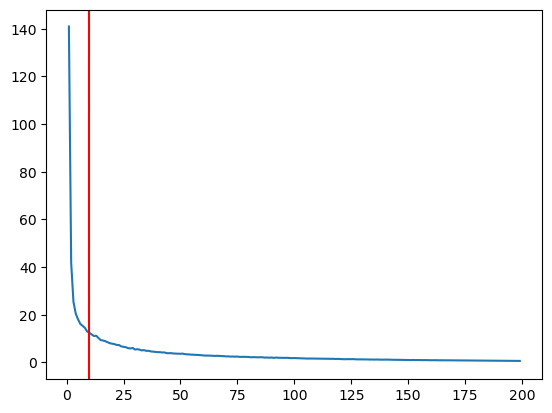

In [13]:
#elbow plot
ls=[]
for i in range(1,200):
    cluster= KMeans(i,max_iter=1000).fit(data)
    ls.append((i,cluster.inertia_))
plt.plot(*zip(*ls))
plt.axline((10,0),(10,1),color='r')

Around 10 clusters looks good.

In [14]:
cluster= KMeans(10).fit(data)
cluster.cluster_centers_

array([[0.10025931, 0.02739416, 0.30814063, 0.76599241],
       [0.97986673, 0.89164354, 0.2111646 , 0.45575062],
       [0.67247399, 0.55011474, 0.27521082, 0.62740568],
       [0.3160812 , 0.21888576, 0.28642153, 0.72217213],
       [0.70987776, 0.43705594, 0.61271634, 0.62626149],
       [0.84001004, 0.70281692, 0.26038985, 0.50265379],
       [0.49291096, 0.39537691, 0.24432336, 0.5937109 ],
       [0.2325978 , 0.06286814, 0.50224209, 0.79801484],
       [0.45097543, 0.22324557, 0.55244567, 0.6465332 ],
       [0.49103623, 0.34991408, 0.37632432, 0.77511263]])

In [15]:
#these will be our priors
priors= cluster.cluster_centers_

In [16]:
cluster.inertia_

12.752013916523918

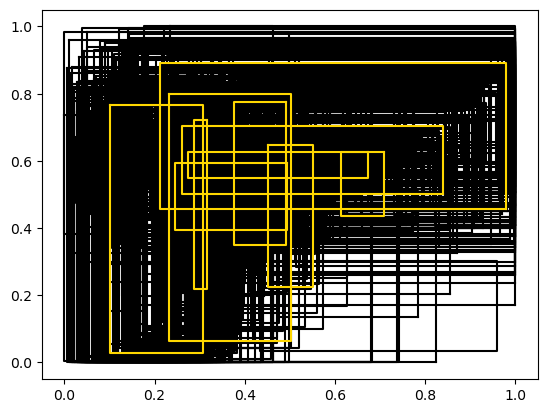

In [17]:
#plotting the bounding boxes to visualize, all of them are plotted.
fig,ax= plt.subplots()
for i in data:
    xmin,ymin,xmax,ymax=i
    ax.plot([xmin,xmax,xmax,xmin,xmin],[ymax,ymax,ymin,ymin,ymax],color='k')
#along with our priors
for i in priors:
    xmin,ymin,xmax,ymax=i
    ax.plot([xmin,xmax,xmax,xmin,xmin],[ymax,ymax,ymin,ymin,ymax],color='gold')
    
plt.show()

This looks reasonable, all the boxes are unique and diverse, at 20 clusters boxes seem to repeat, saying model is overdoing the clusters.

In [18]:
# now change all the boxes to their normal form and plot the boxes
denorm_data,denorm_priors= data*(D_max-D_min)+D_min, priors*(D_max-D_min)+D_min

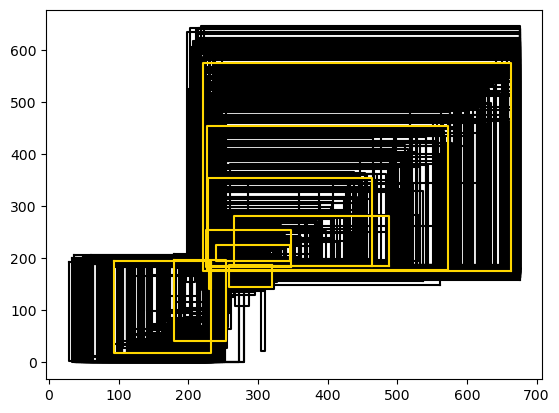

In [19]:
#plotting the bounding boxes to visualize, all of them are plotted.
fig,ax= plt.subplots()
for i in denorm_data:
    xmin,ymin,xmax,ymax=i
    ax.plot([xmin,xmax,xmax,xmin,xmin],[ymax,ymax,ymin,ymin,ymax],color='k')
#along with our priors
for i in denorm_priors:
    xmin,ymin,xmax,ymax=i
    ax.plot([xmin,xmax,xmax,xmin,xmin],[ymax,ymax,ymin,ymin,ymax],color='gold')
    
plt.show()

The priors will be used in traning, the model calculates the offsets from these priors instead of the whole coordinates, this will ease the model's training part.

Another thing i have seen is instead of corner coordinates, they use center coordinates and length and breadth of the rectangle.